In [2]:
# import torch
# print (torch.cuda.is_available())

In [3]:
2+3

5

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import time
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
df1 = pd.read_csv('Dataset/DelhiDataset_named.csv')
df2 = pd.read_csv('Dataset/KolkataDataset_named.csv')
df = pd.concat([df1,df2]).sample(frac=1).reset_index()
df.dropna(inplace=True)
df.shape , df1.shape

((23765, 4), (15438, 3))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23765 entries, 0 to 23766
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       23765 non-null  int64 
 1   Unnamed: 0  23765 non-null  int64 
 2   tweet       23765 non-null  object
 3   label       23765 non-null  object
dtypes: int64(2), object(2)
memory usage: 928.3+ KB


In [8]:
df1.label.value_counts()

Traffic obstruction/car breakdown    4831
Others                               3459
Traffic congestion/heavy traffic     2821
Road closure                         1487
Water logging                        1156
Traffic information/advisory         1001
City program                          416
Accident                              267
Name: label, dtype: int64

In [9]:
df2.label.value_counts()

City program                2150
Roads related congestion    1811
Vehicle breakdown           1636
Closed Avenue               1375
Others                      1103
Road blockage                254
Name: label, dtype: int64

In [10]:
df.label.value_counts()

Traffic obstruction/car breakdown    4831
Others                               4560
Traffic congestion/heavy traffic     2821
City program                         2566
Roads related congestion             1811
Vehicle breakdown                    1636
Road closure                         1487
Closed Avenue                        1375
Water logging                        1156
Traffic information/advisory         1001
Accident                              267
Road blockage                         254
Name: label, dtype: int64

### Merging Similar Data labels as follows
Traffic obstruction/car breakdown = Vehicle breakdown

Traffic congestion/heavy traffic = Roads related congestion

Road closure = Closed Avenue

In [11]:
df.label.replace({'Traffic obstruction/car breakdown':'Vehicle breakdown','Traffic congestion/heavy traffic':'Roads related congestion','Road closure':'Closed Avenue'},inplace=True)

In [12]:
Y = df['label']
Y.value_counts()

Vehicle breakdown               6467
Roads related congestion        4632
Others                          4560
Closed Avenue                   2862
City program                    2566
Water logging                   1156
Traffic information/advisory    1001
Accident                         267
Road blockage                    254
Name: label, dtype: int64

[Text(0, 0, 'Others'),
 Text(1, 0, 'Roads related congestion'),
 Text(2, 0, 'Closed Avenue'),
 Text(3, 0, 'Vehicle breakdown'),
 Text(4, 0, 'Traffic information/advisory'),
 Text(5, 0, 'Water logging'),
 Text(6, 0, 'City program'),
 Text(7, 0, 'Accident'),
 Text(8, 0, 'Road blockage')]

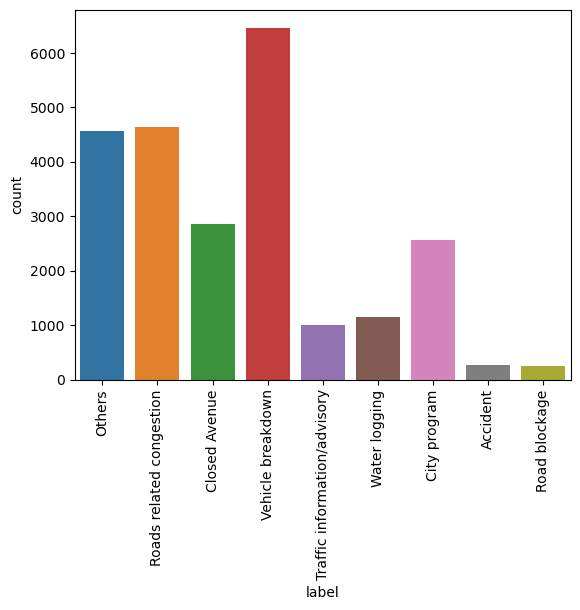

In [13]:
s = sns.countplot(x='label',data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

## Dataset Preprocessing

In [14]:
lb = LabelBinarizer()
y = lb.fit_transform(Y)
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

## Devide Data into Train Test

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['tweet'],y, stratify=df['label'])
X_train.shape, X_test.shape

((17823,), (5942,))

In [16]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [39]:
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    print(preprocessed_text['input_type_ids'])
    print(preprocessed_text['input_mask'])
    print(preprocessed_text['input_word_ids'])

    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
    'Hello My name is Pratik',
    #'You have won a lottery! please click the link to accept it'
    ])

tf.Tensor(
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[  101  7592  2026  2171  2003 10975 10450  2243   102     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
     

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.85339785, -0.4827678 , -0.7047719 ,  0.72218126,  0.47630113,
        -0.12898602,  0.8794483 ,  0.29697904, -0.5190278 , -0.9999407 ,
        -0.18897173,  0.8427548 ,  0.97859085,  0.3261538 ,  0.9221677 ,
        -0.6612023 , -0.2909713 , -0.62822235,  0.34081355, -0.27214998,
         0.68391585,  0.99982375,  0.31350812,  0.3337943 ,  0.4212491 ,
         0.94984674, -0.75676495,  0.92821467,  0.9548833 ,  0.6386579 ,
        -0.61216587,  0.22108905, -0.98511225, -0.22265474, -0.78967494,
        -0.9853174 ,  0.3458662 , -0.7285136 , -0.13372713,  0.05549078,
        -0.8996963 ,  0.34935078,  0.99982613, -0.4931752 ,  0.38140148,
        -0.40842298, -0.9999994 ,  0.23310149, -0.8767495 ,  0.7179888 ,
         0.69241565,  0.5395154 ,  0.18618739,  0.41286173,  0.46317342,
         0.2160901 , -0.0770764 ,  0.16406378, -0.30028713, -0.5886641 ,
        -0.6664573 ,  0.4740787 , -0.69982004, -0.90390277,  0.6105612 ,
 

# BERT Model Configuration

In [40]:
encoder_layer

{'pooled_output': <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer_1')>,
 'sequence_output': <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_1')>,
 'encoder_outputs': [<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'keras_layer_1')>,
  <KerasTensor: shape=(None, 128, 768) dtype=float32

In [30]:
len(encoder_layer['encoder_outputs'])

12

In [19]:
# Bert Layers
text_input_layer = tf.keras.Input(shape=(),dtype=tf.string,name='input')
preprocessed_text_layer = bert_preprocess(text_input_layer)
encoder_layer = bert_encoder(preprocessed_text_layer)

# Neural network layers
n2 = tf.keras.layers.Dense(128, activation='ReLU', name="Dense1")(n1)
n1 = tf.keras.layers.Dropout(0.1,name = 'DropOut')(encoder_layer['pooled_output'])
output = tf.keras.layers.Dense(len(lb.classes_), activation='softmax', name="Output")(n1)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input_layer], outputs = [output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input[0][0]']                  
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

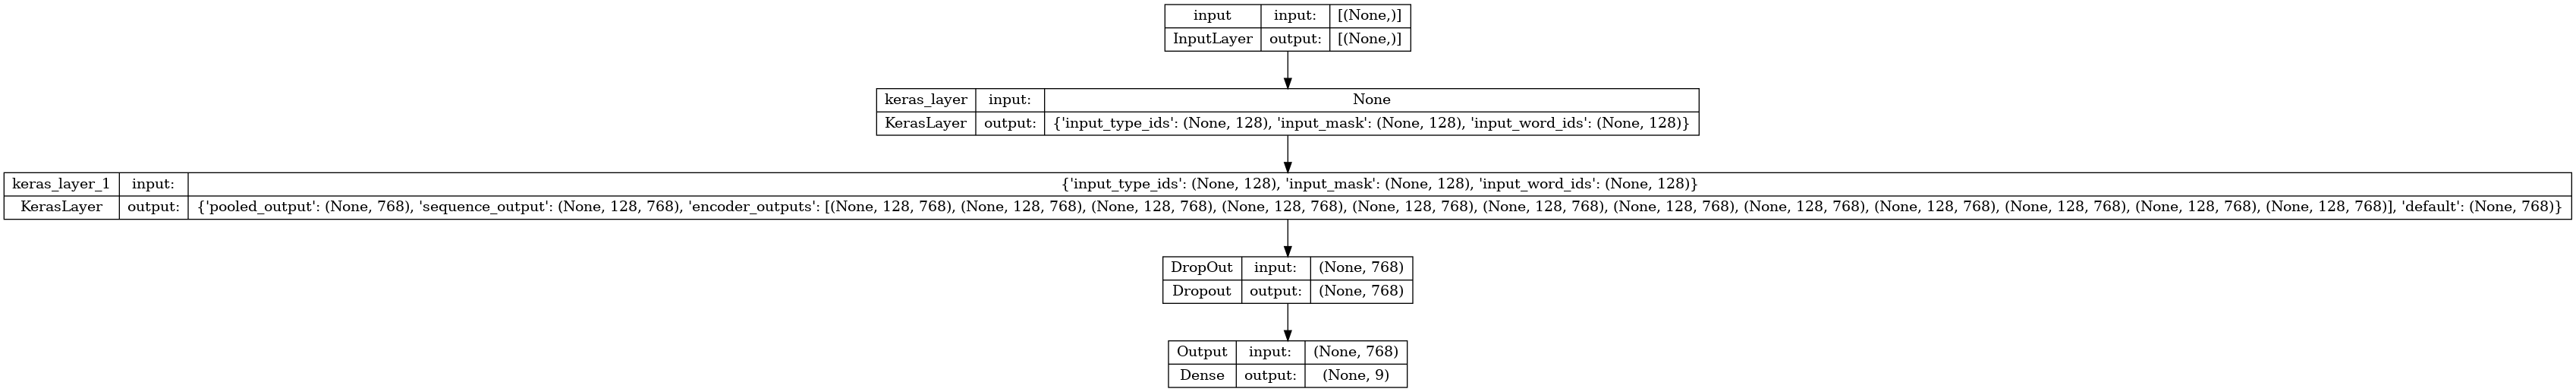

In [21]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='BERT.png', show_shapes=True)

In [35]:
!pip install pydot  graphviz

Defaulting to user installation because normal site-packages is not writeable


In [16]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [18]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import keras
st = time.time()
epochs = 5
batch_size = 32

checkpoint_path = '/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BERT-Merged/cp-{epoch:03d}-{accuracy:0.4f}.hdf5'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor = 'loss',
    mode = min,
    save_best_only = True,
    verbose=1)

history = model.fit(X_train, Y_train, epochs = epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),cp_callback])

et = time.time()
elapsed_time = et - st
print('Execution time: {:0.0f} seconds'.format(elapsed_time))

model.save('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/Bert-Merged_model.h5')

import pickle
with open('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/Bert-Merged_history', 'wb') as file_pi:
    pickle.dump(history, file_pi)

Epoch 1/50
502/502 [==============================] - ETA: 0s - loss: 1.6129 - accuracy: 0.4251
Epoch 1: loss improved from inf to 1.61289, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BERT-Merged/cp-001-0.4251.hdf5
502/502 [==============================] - 1343s 3s/step - loss: 1.6129 - accuracy: 0.4251 - val_loss: 1.3878 - val_accuracy: 0.5558
Epoch 2/50
502/502 [==============================] - ETA: 0s - loss: 1.3511 - accuracy: 0.5429
Epoch 2: loss improved from 1.61289 to 1.35114, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BERT-Merged/cp-002-0.5429.hdf5
502/502 [==============================] - 1281s 3s/step - loss: 1.3511 - accuracy: 0.5429 - val_loss: 1.2735 - val_accuracy: 0.5373
Epoch 3/50
502/502 [==============================] - ETA: 0s - loss: 1.2323 - accuracy: 0.5895
Epoch 3: loss improved from 1.35114 to 1.23226, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BERT-Merged/cp-003-0.5895.hdf5
502/50

# Load Model, History and Dataset

In [ ]:
# import keras

# newmodel = tf.keras.models.load_model('Bert_Kolkata_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# # new_model = tf.keras.models.load_model('saved_model/my_model')

In [ ]:
# model.summary()

In [ ]:
# import pickle
# with open('Bert_Kolkata_history', "rb") as file_pi:
#     newhistory = pickle.load(file_pi)

In [ ]:
# with open('KolkataTrainTestData', 'rb') as file_pi:
#     temp = pickle.load(file_pi)
# X_train = temp[0] 
# X_test = temp[1]
# y_train = temp[2]
# y_test = temp[3]

## Perform on Test Data

In [19]:
accr = model.evaluate(X_test,Y_test)
print("Accuracy of model on test data : " , accr[1]*100 , "%")

186/186 [==============================] - 419s 2s/step - loss: 0.8080 - accuracy: 0.7338
Accuracy of model on test data :  73.37597012519836 %


## Result Analysis
### Plot Training Testing Accuracy and Loss

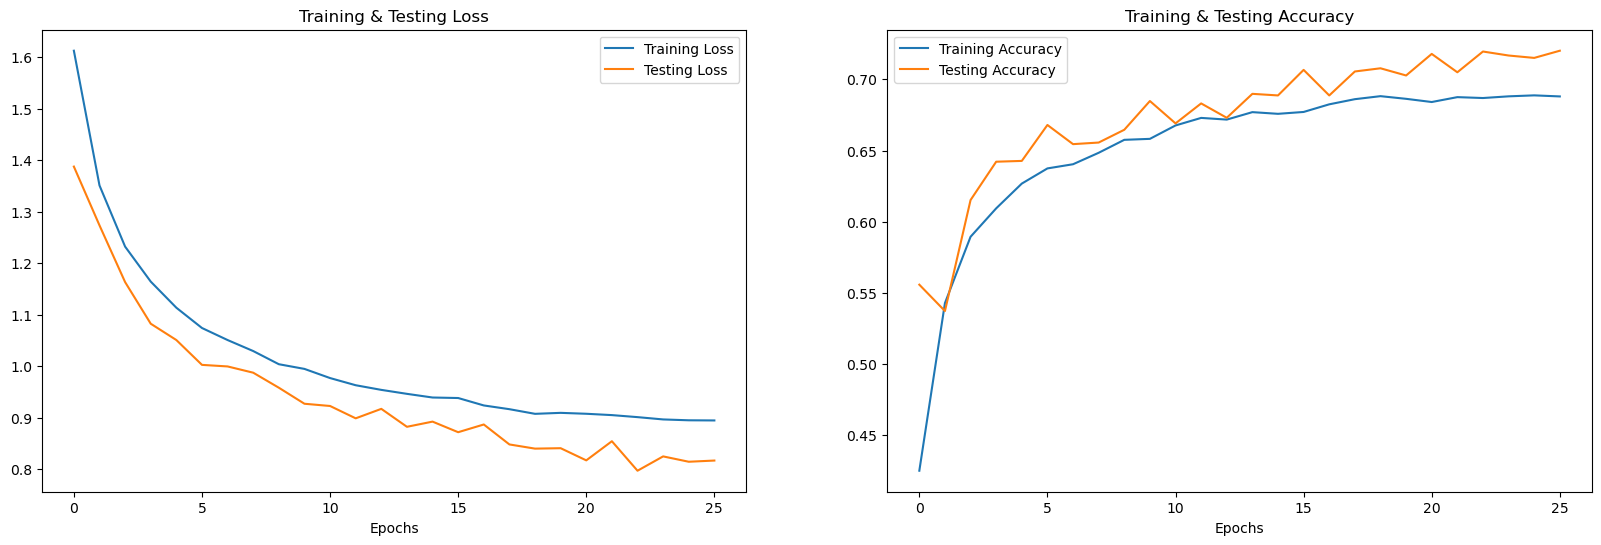

In [20]:
epochList = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochList , train_loss , label = 'Training Loss')
ax[0].plot(epochList , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochList , train_acc , label = 'Training Accuracy')
ax[1].plot(epochList , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

### Prediction of Model on Test Data

In [21]:
pred_test = model.predict(X_test)

186/186 [==============================] - 416s 2s/step


In [22]:
y_pred = lb.inverse_transform(pred_test)
y_test = lb.inverse_transform(Y_test)

In [23]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[['Accident' '67']
 ['City program' '642']
 ['Closed Avenue' '716']
 ['Others' '1140']
 ['Road blockage' '63']
 ['Roads related congestion' '1158']
 ['Traffic information/advisory' '250']
 ['Vehicle breakdown' '1617']
 ['Water logging' '289']]


### Plotting Confusion Matrix

<Figure size 3000x1000 with 0 Axes>

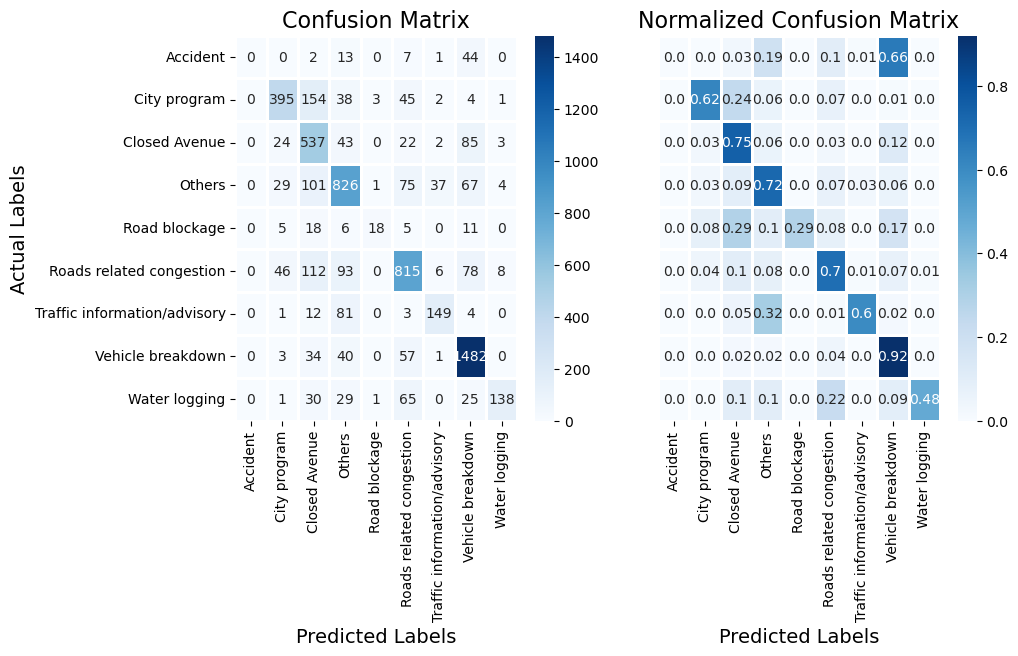

In [24]:
cm = confusion_matrix(y_test, y_pred)
cm1 = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
plt.figure(figsize = (30, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
cm1 = pd.DataFrame(cm1  , columns = [i for i in lb.classes_])

fig , ax = plt.subplots(1,2,figsize=(10,5))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=2, annot=True, fmt='',ax=ax[0])
ax[0].set_title('Confusion Matrix', size=16)
ax[0].set_xlabel('Predicted Labels', size=14)
ax[0].set_ylabel('Actual Labels', size=14)

sns.heatmap(cm1, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='',ax=ax[1],yticklabels=False)
ax[1].set_title('Normalized Confusion Matrix', size=16)
ax[1].set_xlabel('Predicted Labels', size=14)
plt.show()

In [25]:
# cm = confusion_matrix(y_test, y_pred)
# # cm= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
# plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
# sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
# plt.title('Confusion Matrix', size=20)
# plt.xlabel('Predicted Labels', size=14)
# plt.ylabel('Actual Labels', size=14)
# plt.show()

# cm = confusion_matrix(y_test, y_pred)
# cm= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
# plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
# sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
# plt.title('Normalized Confusion Matrix', size=20)
# plt.xlabel('Predicted Labels', size=14)
# plt.ylabel('Actual Labels', size=14)
# plt.show()

In [26]:
print(classification_report(y_test, y_pred))

                              precision    recall  f1-score   support

                    Accident       0.00      0.00      0.00        67
                City program       0.78      0.62      0.69       642
               Closed Avenue       0.54      0.75      0.63       716
                      Others       0.71      0.72      0.72      1140
               Road blockage       0.78      0.29      0.42        63
    Roads related congestion       0.74      0.70      0.72      1158
Traffic information/advisory       0.75      0.60      0.67       250
           Vehicle breakdown       0.82      0.92      0.87      1617
               Water logging       0.90      0.48      0.62       289

                    accuracy                           0.73      5942
                   macro avg       0.67      0.56      0.59      5942
                weighted avg       0.74      0.73      0.73      5942



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


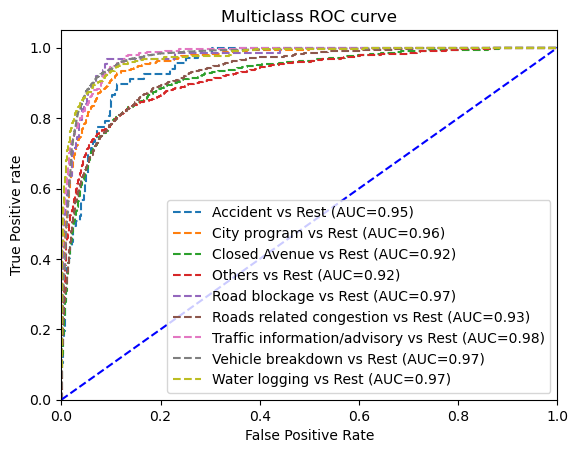

In [27]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,auc

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

classes = lb.classes_

for i in range(len(classes)):
    # fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test[:,i], pred_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

## Calculating Evaluation Metric

In [28]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore,_  = score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, pred_test,multi_class='ovr')
print('Accuracy, precision, recall, fscore, Roc-AUC')
print('{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc))

Accuracy, precision, recall, fscore, Roc-AUC
0.734,0.670,0.563,0.592,0.952


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
print('{},{:.0f},{:.4f},{:.4f}'.format(len(history.history['loss']),elapsed_time,train_acc[-1],test_acc[-1]))

26,32373,0.6880,0.7201


## Test on Customized Tweet

In [30]:
lb.classes_

array(['Accident', 'City program', 'Closed Avenue', 'Others',
       'Road blockage', 'Roads related congestion',
       'Traffic information/advisory', 'Vehicle breakdown',
       'Water logging'], dtype='<U28')

In [31]:
new_complaint = ['Severe accident on 1 no street']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(pred)
print('Label: {}'.format(lb.classes_[np.argmax(pred)]))

NameError: name 'tokenizer' is not defined